# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
# Read in data
df = pd.read_csv('amazon_reviews.csv')
print(df.shape)


In [72]:
df=df.head(500)


In [73]:
df.drop(['reviewerID','asin','summary','reviewerName','helpful','helpful_yes','total_vote'], axis=1, inplace=True)

In [76]:
df.drop(['unixReviewTime','day_diff'], axis=1, inplace=True)

In [77]:
df.to_csv('amazon_reviews500.csv', index=False)

In [78]:
df

,reviewText,overall,reviewTime
0,No issues.,4.0,2014-07-23
1,"Purchased this for my device, it worked as adv...",5.0,2013-10-25
2,it works as expected. I should have sprung for...,4.0,2012-12-23
3,This think has worked out great.Had a diff. br...,5.0,2013-11-21
4,"Bought it with Retail Packaging, arrived legit...",5.0,2013-07-13
...,...,...,...
495,There's not much to be said for this except th...,5.0,2012-12-30
496,As an photographer I rely on high quality card...,5.0,2012-05-12
497,Been using it for a month and everything works...,5.0,2013-09-07
498,This is my 4th unit that I had purchased from ...,5.0,2014-01-31


In [79]:
df=pd.read_csv('amazon_reviews500.csv')

In [80]:
df

,reviewText,overall,reviewTime
0,No issues.,4.0,2014-07-23
1,"Purchased this for my device, it worked as adv...",5.0,2013-10-25
2,it works as expected. I should have sprung for...,4.0,2012-12-23
3,This think has worked out great.Had a diff. br...,5.0,2013-11-21
4,"Bought it with Retail Packaging, arrived legit...",5.0,2013-07-13
...,...,...,...
495,There's not much to be said for this except th...,5.0,2012-12-30
496,As an photographer I rely on high quality card...,5.0,2012-05-12
497,Been using it for a month and everything works...,5.0,2013-09-07
498,This is my 4th unit that I had purchased from ...,5.0,2014-01-31


## Quick EDA

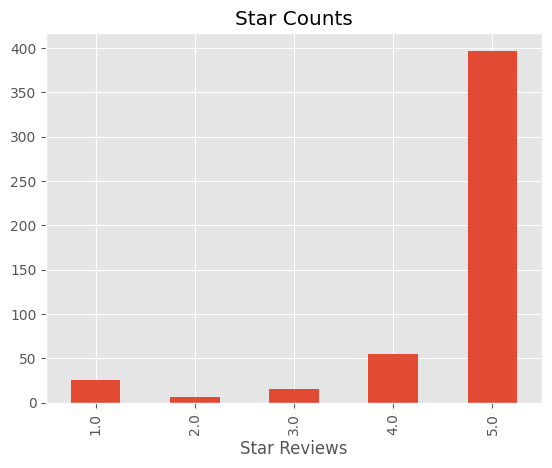

In [92]:
df['overall'].value_counts().sort_index().plot(kind='bar',
         title='Star Counts',xlabel='Star Reviews')

                                              
plt.show()

In [113]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kayum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [112]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Basic NLTK

In [83]:
example = df['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [95]:
tokens = nltk.word_tokenize(example)
tokens[: 10]

['A', 'memory', 'card', 'either', 'works', 'or', 'it', 'does', "n't", '.']

In [103]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('A', 'DT'),
 ('memory', 'NN'),
 ('card', 'NN'),
 ('either', 'CC'),
 ('works', 'VBZ'),
 ('or', 'CC'),
 ('it', 'PRP'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('.', '.')]

In [110]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  does/VBZ
  n't/RB
  ./.
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [114]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [115]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

In [ ]:
sia.polarity_scores(example)

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

## Plot VADER results

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
#from scipy.special import softmax

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like cardiffnlp/twitter-roberta-base-sentiment is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [5]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [9]:
sent_pipeline('I like sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9985498785972595}]

In [10]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [11]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End